## Modelling Population Diffusion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit

### Theory

The hunting and diffusion equation is given by,

$$ru\left(1-\frac{u}{K}\right) - hu + D\nabla^2 u = \frac{\partial u}{\partial t}$$

Using finite difference method,

$$ru_{i,j}^{(t)} \left(1 - \frac{u_{i,j}^{(t)}}{K} \right) - hu_{i,j}^{(t)} + D \left( \frac{u_{i+1,j}^{(t)} -2u_{i,j}^{(t)} + u_{i-1,j}^{(t)}}{\Delta x^2} + \frac{u_{i,j+1}^{(t)} -2u_{i,j}^{(t)} + u_{i,j-1}^{(t)}}{\Delta y^2}\right) = \frac{u_j^{(t+1)} - u_j^{(t)}}{\Delta t} $$ 

$$(r-h)u_{i,j}^{(t)} - \frac{r(u_{i,j}^{(t)})^2}{K} + D \left( \frac{u_{i+1,j}^{(t)} -2u_{i,j}^{(t)} + u_{i-1,j}^{(t)}}{\Delta x^2} + \frac{u_{i,j+1}^{(t)} -2u_{i,j}^{(t)} + u_{i,j-1}^{(t)}}{\Delta y^2}\right) = \frac{u_j^{(t+1)} - u_j^{(t)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(t+1)} = u_j^{(t)} + \Delta t\left[(r-h)u_{i,j}^{(t)} - \frac{r(u_{i,j}^{(t)})^2}{K} + \frac{D}{\Delta x^2} \left( u_{i+1,j}^{(t)} + u_{i-1,j}^{(t)} +  u_{i,j+1}^{(t)} + u_{i,j-1}^{(t)}  -4u_{i,j}^{(t)} \right)\right] $$

### Implementation

Initialise space grid with random spawns

In [2]:
n = 100
i = 5
coords = np.array([(np.random.randint(i, n-i), np.random.randint(i, n-i)) for _ in range (50)])
init_population = np.zeros((n, n))
for x, y in coords:
    init_population[x,y] = 2

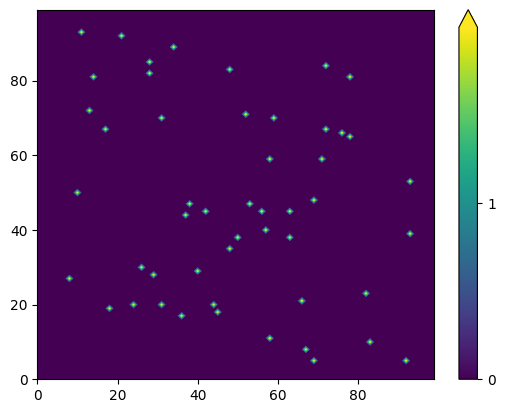

In [3]:
fig,ax = plt.subplots()
vmin,vmax = int(np.min(init_population)), int(np.max(init_population))
contourf_ = ax.contourf(init_population, levels=np.linspace(vmin,vmax,400),extend='max')
cbar = fig.colorbar(contourf_,ticks=range(vmin, vmax))

diffusion constant

In [4]:
D = 0.01

Set the dimensions of the problem

In [2]:
x = 1
dx = 0.05
dt = 0.0001

In [ ]:
total_time = 20 # sec
times = 36000*7#int(total_time/dt
times_snapshot = 3600
f = int(times/times_snapshot)
population_frames = np.zeros([times_snapshot, 100, 100])
population_frames[0] = init_population
population_size = np.zeros(times)

* Number of differential equation update iterations `times`
* Number of snapshots we will take `times_snaphot`. 
* The array of snapshots we will take of the turkey


In [32]:
print(f'Snapshot taken every {f}th frame.')
print(f'Total time of simulation is {times*dt} sec.')
print(f'Snapshot taken every {f*dt} sec.')

Snapshot taken every 70th frame.
Total time of simulation is 25.200000000000003 sec.
Snapshot taken every 0.007 sec.


Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [8]:
D * dt / dx**2

0.00039999999999999996

### Solving the PDE

Set up numba function

In [ ]:
@numba.jit("(f8[:,:,:], f8, f8, f8)", nopython=True, nogil=True, fastmath = True)
def solve_pde(environment, K, r, h):
    cs = environment[0].copy() #current state
    length = len(cs[0])
    density = np.zeros(times)
    density[0] = np.average(cs) # average population density
    cf = 0 # current frame

    for t in range(1, times):
        ns = cs.copy() # new state

        for i in range(1, length-1):
            for j in range(1, length-1):
                ns[j][i] = cs[j][i] + D*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i]) +\
                                                    dt*((r-h)*cs[j][i] - (r*cs[j][i]**2)/K)

        ns[:,0] = ns[:,1] # left neumann
        ns[:,-1] = ns[:,-2] # right neumann
        ns[0,:] = ns[1,:] # top neumann
        ns[-1,:] = ns[-2,:] # bottom neumann
        
        density[t] = np.average(cs)
        cs = ns.copy()
        if t%f==0: # take snapshot
            cf = cf + 1
            environment[cf] = cs
            
    return environment, density

Get population snapshots and population size over time plot

6708.324283473497

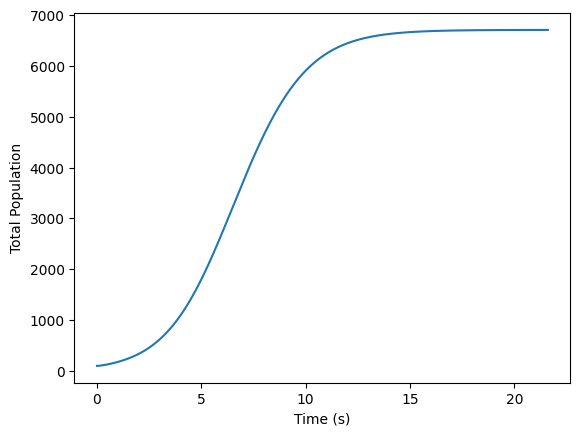

In [ ]:
K, r, h = 1, 0.9, 0.2
population_frames, population_sizes = solve_pde(population_frames, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
population_sizes[-1]

Get population snapshots and population size over time plot

The final snapshot

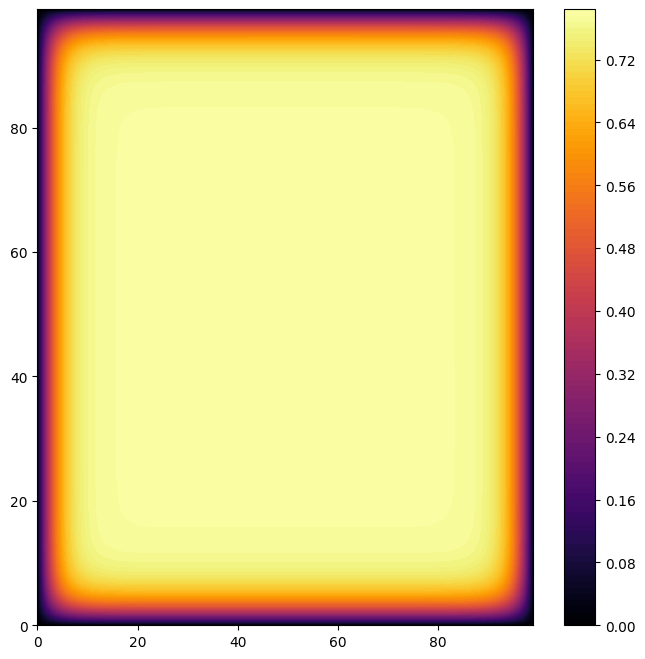

In [ ]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(population_frames[-1], 100, cmap=my_cmap)
plt.colorbar(a)

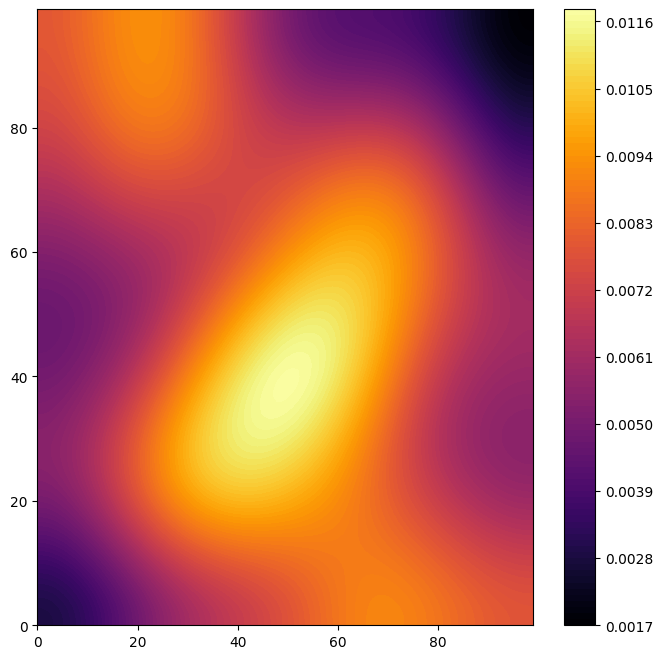

In [23]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(population_frames[-1], 100, cmap=my_cmap)
plt.colorbar(a)

In [24]:
np.save(f'modelled data/hunting/neumann_r9', population_frames)

Make animation

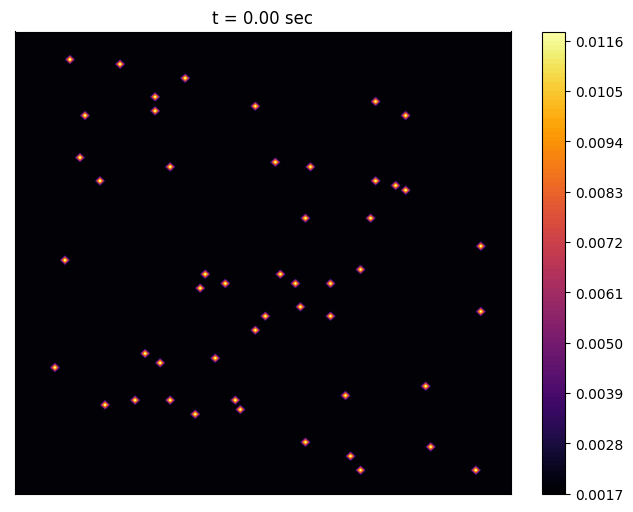

In [25]:
def animate(i):
    ax.clear()
    a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=my_cmap) #put vmin and vmax
    plt.title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

fig, ax = plt.subplots(figsize=(8,6))
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('population_neumannr9.gif',writer='pillow',fps=30)

### Simulational Animations

Neumann BC $(r = 0.9, h=0)$

In [2]:
from IPython.display import Image
Image(url='plots/5/5b/population_neumannr0.gif')

Neumann BC $(r = 0.9, h=0.5)$

In [3]:
Image(url='plots/5/5b/population_neumannr5.gif')

Neumann BC $(r = 0.9, h=0.9)$

In [4]:
Image(url='plots/5/5b/population_neumannr9.gif')

Neumann BC $(r = 0.9, h=0.2)$

In [ ]:
Image(url='plots/5/5b/population1_neumann.gif') 

Dirichlet BC $(r = 0.9, h=0.2)$

In [9]:
Image(url='plots/5/5b/population_dirc.gif')

### Plotting Diffusion

In [4]:
compare_sizes = {} 
my_cmap = plt.get_cmap('inferno')

In [21]:
loc = 'modelled data/hunting'
name='neumann_r9'
modelled_frames = np.load(f'{loc}/{name}.npy')

In [22]:
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

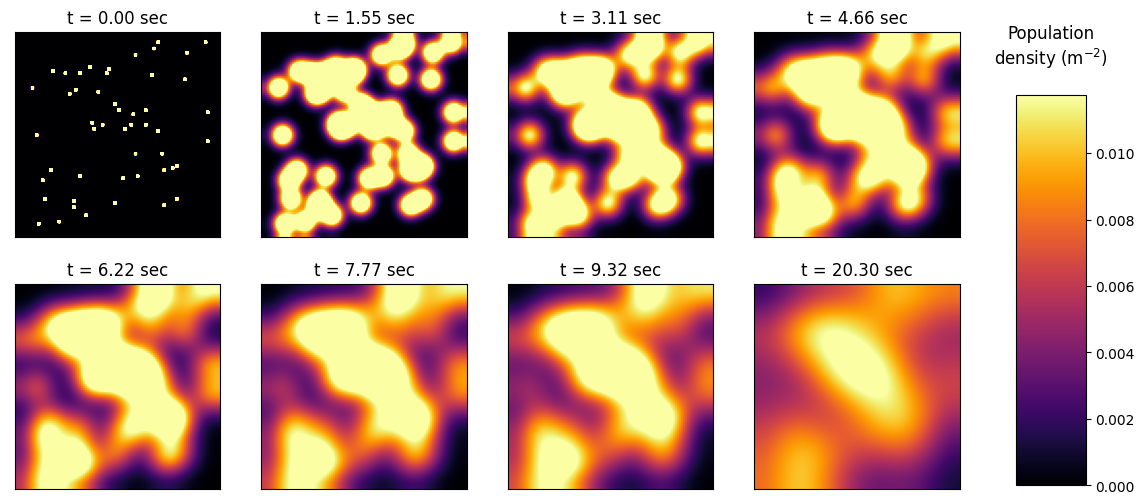

In [23]:
show_frame_id = [int(2000/9)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2900], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2900:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5b/{name}_spread.png', bbox_inches='tight')
plt.show()

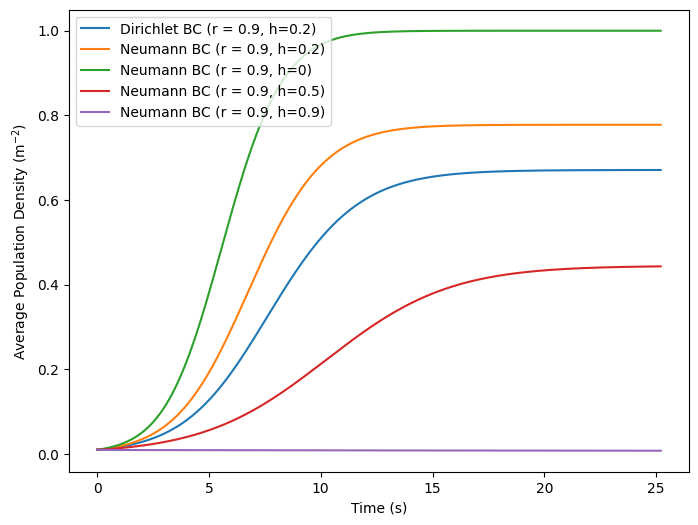

In [ ]:
labels = {
    'neumann_r0': 'Neumann BC (r = 0.9, h=0)',
    'neumann_r5': 'Neumann BC (r = 0.9, h=0.5)',
    'neumann_r9': 'Neumann BC (r = 0.9, h=0.9)',
    'neumann': 'Neumann BC (r = 0.9, h=0.2)',
    'dirchlet': 'Dirichlet BC (r = 0.9, h=0.2)'
}
plt.figure(figsize=(8,6))
for model in compare_sizes:
    plt.plot(np.linspace(0, times*dt, 1800), compare_sizes[model], label=labels[model])

plt.xlabel('Time (s)')
plt.ylabel(r'Average Population Density (m$^{-2}$)')
plt.legend()
plt.savefig(f'plots/5b/all_sizes.png', bbox_inches='tight')